In [1]:
from google.cloud import bigquery
from datastory import DataStory
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as plio
import datetime as dt
import os 
import locale
from datetime import timedelta
from dateutil.relativedelta import relativedelta

pd.set_option('display.max_colwidth', None)


import altair as alt
alt.data_transformers.enable('json')
alt.data_transformers.enable('default')
from altair.expr import datum, substring

In [2]:
pd.set_option('display.max_colwidth', None)

nav_kategorisk =  ['#66CBEC', '#0067C5', '#FF9100', '#BA3A26', '#634689', '#F0C419', '#06893A']
nav_kat_for = ['#BA3A26', '#FF9100', '#0067C5', '#66CBEC']
nokkeltall_farge = '#CCE1F3'
annotation_text = "NB! Dette plottet er ikke offisiell statistikk og må ikke deles utenfor NAV."

i_dag = dt.date.today().strftime('%Y-%m-%d')



# +
#####################################################################################################################################################
###  Funksjon for å legge sykmeldingene som kommer inn i helgen til mandagen etter, dette er for å kunne sammenlikne med årene før. Kan revideres ###
#####################################################################################################################################################

def Helg(ukedag, dato):
    ny_dato = dato
    if ukedag == 'Sat':
        ny_dato = dato + relativedelta(days=2)
    if ukedag == 'Sun':
        ny_dato = dato + relativedelta(days=1)
    return ny_dato


# -

### Tilfeller hvor noe av desember er i uke 1 eller noe av januar er i uke 53, gjør grafen rar -- disse flyttes til året etter eller året før (kun for grafen)  ###
def ukenummer_fiks_aar(mnd, uke, aar):
    mnd = mnd
    uke = uke
    aar = aar
    if mnd == '12' and uke == '01':
        aar = str(int(aar)+1)
    elif mnd == '01' and uke == '53':
        aar = str(int(aar)-1)
    elif mnd == '01' and uke == '52':
        aar = str(int(aar)-1)
    return aar


# +
## Fikser krøll med uke i årsskiftet når vi har formatet YYYY/V (år/uke) ##

def ukenummer_fiks_uke(uke, dato):
    uke = uke
    if dato.strftime('%V') == '53' and dato.month == 1:
        uke = str(int(dato.strftime('%Y'))-1) + '/' + dato.strftime('%V')
    elif dato.strftime('%V') == '01' and dato.month == 12:
        uke = str(int(dato.strftime('%Y'))+1) + '/' + dato.strftime('%V')
    elif dato.strftime('%V') == '52' and dato.month == 1:
        uke = str(int(dato.strftime('%Y'))-1) + '/' + dato.strftime('%V')
    return uke 


# -

## Lage liste ## 
def makeList(liste):
    new_list = '(' 
    for i in liste:
        new_list += '\'' + i + '\'' + ','
    new_list = new_list[:-1] + ')'
    return new_list


# +
##############################################################
### Finner behandlingsutfall i tilbakedaterte sykmeldinger ###
##############################################################

def make_status(merknad, behandlingsutfall):
    status = 'status'
    if merknad == None and behandlingsutfall == 'OK': 
        status = 'OK'
    else:
        status = 'INVALID'
    return status


# +
#############################################################################
### Definerer en sykmelding som ubrukt dersom den har vært åpen i >= 1 år ###
#############################################################################

def er_ubrukt(event, dato):
    event = event
    if event == 'APEN' and dato >=365:
        event = 'Ubrukt'
    else: event = event
    return event
# -



# +
####################################################################################################
### Map for å klassifisere regeltreff til infotrygd regler eller ikke infotrygd regler (manuell) ###
###           Her med de gamle reglene som ukjent                                                ###
####################################################################################################

map_regel_manu = {
        'NUMBER_OF_TREATMENT_DAYS_SET' : 'Manuell (infotrygdregler)',
        'BEHANDLER_KI_FT_MT_BENYTTER_ANNEN_DIAGNOSEKODE_ENN_L' : 'Manuell',
        'TILBAKEDATERT_MED_BEGRUNNELSE_FORLENGELSE' : 'Manuell', 
        'TSS_IDENT_MANGLER' : 'Manuell (infotrygdregler)',
        'ERROR_FROM_IT_HOUVED_STATUS_KODEMELDING' : 'Manuell (infotrygdregler)',
        'NEW_CLEAN_BILL_DATE_BEFORE_ARBUFORTOM' : 'Manuell (infotrygdregler)',
        'PARTIALLY_COINCIDENT_SICK_LEAVE_PERIOD_WITH_PREVIOUSLY_REGISTERED_SICK_LEAVE' : 'Manuell (infotrygdregler)',
        'PARTIALLY_COINCIDENT_SICK_LEAVE_PERIOD_WITH_PREVIOUSLY_REGISTERED_SICK_LEAVE_1' : 'Manuell (infotrygdregler)',
    
        'AVVENTENDE_SYKMELDING_KOMBINERT' : 'Avvist',
        'DEGREE_OF_DISABILITY_IS_CHANGED' : 'Ukjent',
        'GRADERT_REISETILSKUDD_ER_OPPGITT' : 'Manuell (infotrygdregler)',
        'GRADUAL_SYKMELDING_COMBINED_WITH_TRAVEL    ' : 'Ukjent',
        'NEW_CLEAN_BILL_DATE_BEFORE_PAYOUT' : 'Manuell (infotrygdregler)',
        'NEW_CLEAN_BILL_DATE_BEFORE_REGISTERD_CLEAN_BILL_DATE' : 'Manuell (infotrygdregler)',
        'PATIENT_NOT_IN_IP' : 'Manuell (infotrygdregler)', 
        'PERIOD_FOR_AA_ENDED' : 'Manuell (infotrygdregler)', 
        'PERIOD_IS_AF' : 'Manuell (infotrygdregler)',
        'SICKLEAVE_EXTENTION_FROM_DIFFRENT_NAV_OFFICE_2' : 'Manuell (infotrygdregler)',
        'SICKLEAVE_EXTENTION_FROM_DIFFRENT_NAV_OFFICE_3' : 'Manuell (infotrygdregler)',
        'EXTANION_OVER_FA' : 'Manuell (infotrygdregler)', 
        'MAX_SICK_LEAVE_PAYOUT' : 'Manuell (infotrygdregler)',
        'SICKLEAVE_EXTENTION_FROM_DIFFRENT_NAV_OFFICE_1' : 'Manuell (infotrygdregler)',
        'UGYLDIG_KODEVERK_FOR_BIDIAGNOSE' : 'Avvist', 
        'PERSON_MOVING_KODE_FL' : 'Manuell (infotrygdregler)',
        'PASIENTEN_HAR_KODE_6' : 'Manuell', 
        'ARBEIDUFORETOM_MANGLER' : 'Manuell (infotrygdregler)',
        'UFOREGRADEN_ER_100_OG_HOYERE_ENN_I_INFOTRYGD' : 'Ukjent',
        'TEKNISK_FEIL' : 'Ukjent',
        'ERROR_FROM_IT_DIAGNOSE_OK_UTREKK_STATUS_KODEMELDING' : 'Manuell (infotrygdregler)',
        'ERROR_FROM_IT_PARALELLYTELSER_STATUS_KODEMELDING' : 'Manuell (infotrygdregler)',
        'ERROR_FROM_IT_PASIENT_UTREKK_STATUS_KODEMELDING' : 'Manuell (infotrygdregler)',
        'ERROR_FROM_IT_SMHISTORIKK_STATUS_KODEMELDING' : 'Manuell (infotrygdregler)',
        'GRADERT_TRAVEL_SUBSIDY_SPECIFIED' : 'Ukjent',
        'GRADUAL_SYKMELDING_COMBINED_WITH_TRAVEL' : 'Manuell',
        'TILBAKEDATERT_MED_BEGRUNNELSE_FORSTE_SYKMELDING' : 'Ukjent',
        'TRAVEL_SUBSIDY_SPECIFIED' : 'Manuell (infotrygdregler)',
        'UFOREGRADEN_ER_HOYERE_ENN_I_INFOTRYGD' : 'Ukjent',
        'TILBAKEDATERT_MER_ENN_8_DAGER_FORSTE_SYKMELDING_MED_BEGRUNNELSE' : 'Manuell',
        'HOVEDDIAGNOSE_MANGLER' : 'Ukjent',
    
        'AVVENTENDE_SYKMELDING_OVER_16_DAGER' : 'Avvist',
        'BEHANDLER_MANGLER_AUTORISASJON_I_HPR' : 'Avvist',
        'TILBAKEDATERT_FORLENGELSE_OVER_1_MND' : 'Avvist',
        'TILBAKEDATERT_MER_ENN_8_DAGER_FORSTE_SYKMELDING' : 'Avvist',
        'FRADATO_ETTER_TILDATO' : 'Avvist', 
        'FREMDATERT' : 'Avvist',
        'GRADERT_SYKMELDING_UNDER_20_PROSENT' : 'Avvist', 
        'OVERLAPPENDE_PERIODER' : 'Avvist',
        'GRADERT_SYKMELDING_OVER_99_PROSENT' : 'Avvist', 
        'OPPHOLD_MELLOM_PERIODER' : 'Avvist',
        'PASIENT_ELDRE_ENN_70' : 'Avvist', 
        'VARIGHET_OVER_ETT_AAR' : 'Avvist',
        'FOR_MANGE_BEHANDLINGSDAGER_PER_UKE' : 'Avvist',
        'BEHANDLER_IKKE_GYLDIG_I_HPR' : 'Avvist', 
        'BEHANDLER_IKKE_LE_KI_TL_FT_I_HPR' : 'Avvist',
        'PASIENT_YNGRE_ENN_13' : 'Avvist', 
        'ICPC_2_Z_DIAGNOSE' : 'Avvist',
        'TILBAKEDATERT_MER_ENN_3_AR' : 'Avvist', 
        'SYKMELDING_MED_BEHANDLINGSDAGER' : 'Manuell',
        'SYKMELDING_MED_REISETILSKUDD' : 'Manuell'
        
                 }

In [3]:
client = bigquery.Client()

In [4]:
## For å endre antall år vi tar med i grafen er det bare å endre tallet her. Tar nå med fire år
aar = str(int(dt.date.today().strftime('%Y')) - 4)

query_job = client.query(
    f"""
    select CAST(so.mottatt_tidspunkt AS DATE) mottatt_tidspunkt,
       count(sd.id) antall
from `teamsykmelding-prod-2acd.syfosmregister.sykmeldingsopplysninger` so, `teamsykmelding-prod-2acd.syfosmregister.behandlingsutfall` bh, `teamsykmelding-prod-2acd.syfosmregister.sykmeldingsdokument` sd
where so.id = bh.id
and so.id = sd.id
and so.mottatt_tidspunkt > CAST('{aar}-12-31' AS DATE)

and JSON_EXTRACT(bh.behandlingsutfall, '$.status') in ('"OK"', '"MANUAL_PROCESSING"')

group by CAST(so.mottatt_tidspunkt AS DATE)
    
    """
)

df = query_job.result().to_dataframe()

In [5]:
### Passer på at dato er i riktig format ### 

df['mottatt_tidspunkt'] = df['mottatt_tidspunkt'].astype('datetime64[ns]')

In [6]:
### Ny df som får nye kolonner med uke og ukedag ###
df_total = df.copy()
df_total['Uke'] = df_total['mottatt_tidspunkt'].dt.strftime('%V')
df_total['Ukedag'] = df_total['mottatt_tidspunkt'].dt.strftime('%a')
df_total['Måned'] = df_total['mottatt_tidspunkt'].dt.strftime('%m')

In [7]:
### Bruker funksjonen for å flytte helge-sykmeldingene til mandagen etter ###

df_tot_fig = df_total.copy()
df_tot_fig['date'] = df_tot_fig.apply(
    lambda x: Helg(x['Ukedag'], x['mottatt_tidspunkt']), 
    axis=1
)

In [8]:
### Grupperer  etter dato ###
df_total_grouped = df_tot_fig.copy()
df_total_grouped = df_total_grouped.groupby(['date']).sum().reset_index()

### Legger til kolonner med kalenderinfo ###
df_total_grouped['År'] = df_total_grouped['date'].dt.strftime('%Y')
df_total_grouped['Måned'] = df_total_grouped['date'].dt.strftime('%m')
df_total_grouped['Uke'] = df_total_grouped['date'].dt.strftime('%V')
df_total_grouped['Ukedag'] = df_total_grouped['date'].dt.strftime('%a')
df_total_grouped['Uke+dag'] = df_total_grouped['date'].dt.strftime('%V / %a')

In [9]:
### Vil ikke ha med dagens dato ###
df_total_grouped = df_total_grouped[df_total_grouped['date'] != dt.date.today().strftime('%Y-%m-%d')].copy()
df_total_grouped['År'] = df_total_grouped.apply(
    lambda x: ukenummer_fiks_aar(x['Måned'], x['Uke'], x['År']), 
    axis=1
)

In [11]:
### Fiks for å få riktig rekkefølge i plottet ###

df_total_grouped = df_total_grouped.sort_values(by=['År', 'Uke', 'date'])
ukedag_list = df_total_grouped['Uke+dag'].unique().tolist()
flytte = '01 / Mon'
ukedag_list.remove(flytte)
ukedag_list.insert(0, flytte)

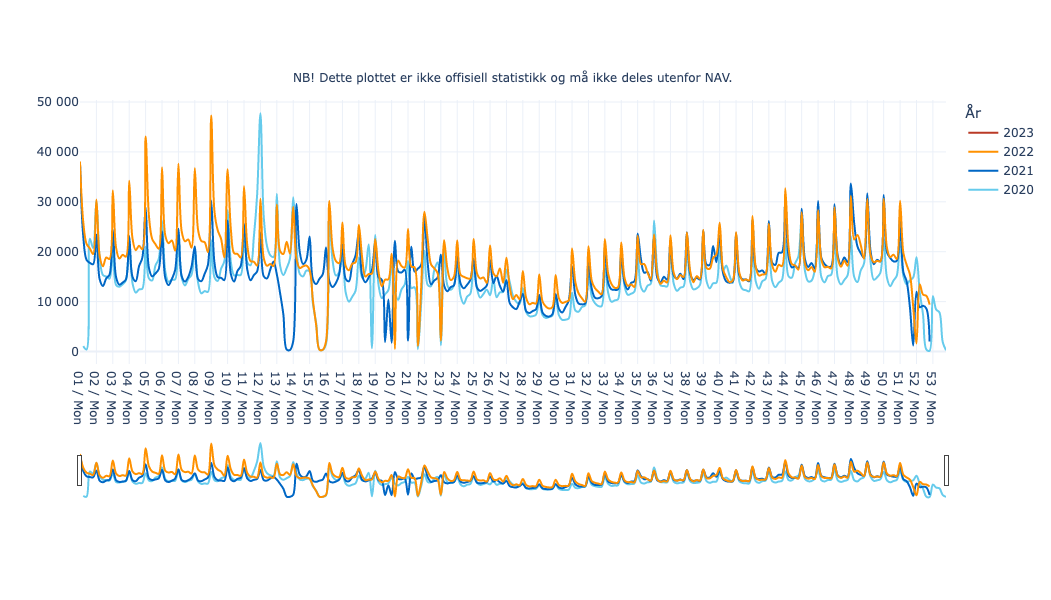

In [12]:
### Figur over antall sykmeldinger mottatt over samme periode siste tre årene ###

fig_sykmeldinger = px.line(
    df_total_grouped, 
    x='Uke+dag', 
    y='antall', 
    color='År',
    labels={'antall': '', 
            'Uke+dag': ''},
    hover_name='År', 
    line_shape='spline',
    render_mode = "svg",
    color_discrete_sequence = nav_kategorisk,
    category_orders = {'Uke+dag' : ukedag_list}
    
)

fig_sykmeldinger.update_layout(
    yaxis=dict(tickformat=',d'), 
    separators=', ', 
    hovermode='x unified'
)

fig_sykmeldinger.for_each_trace(
    lambda trace: trace.update(name=trace.name.replace("=", ": " )),
)

n = df_total_grouped['År'].nunique()-1

for i in range(-1,n):
    fig_sykmeldinger['data'][i]['hovertemplate'] = '%{hovertext}<br />Antall: %{y}<extra></extra>'

    
    
fig_sykmeldinger.add_annotation(
    text = annotation_text,
    showarrow= False,
    align= 'center',
    x= 0.5,
    y= 1.12,
    xref= 'paper',
    yref= 'paper'
)

fig_sykmeldinger.update_layout(
    dragmode="zoom",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    xaxis=dict(
        autorange=True,
        rangeslider=dict(
            autorange=True
        )
    )
)

In [441]:
query_job = client.query("""
select CAST(so.mottatt_tidspunkt AS DATE) dato,
    count(distinct so.id) totalt
from `teamsykmelding-prod-2acd.syfosmregister.sykmeldingsopplysninger` so
where so.epj_system_navn='Papirsykmelding' 
group by CAST(so.mottatt_tidspunkt AS DATE)
""")

df_papir = query_job.result().to_dataframe()

In [442]:
df_papir = df_papir[df_papir['dato'] != dt.datetime.now().date()]

In [443]:
df_papir['dato'] = df_papir['dato'].astype('datetime64[ns]')

In [444]:
query_job = client.query("""

select count(id) antall, CAST(dato_opprettet AS DATE) dato from `teamsykmelding-prod-2acd.smregistrering_backend.manuelloppgave`
where ferdigstilt is True
group by CAST(dato_opprettet AS DATE)


""")

df_registrering = query_job.result().to_dataframe()

In [445]:
query_job = client.query("""

select count(id) antall, ferdigstilt, CAST(dato_opprettet AS DATE) dato from `teamsykmelding-prod-2acd.smregistrering_backend.manuelloppgave`
group by CAST(dato_opprettet AS DATE), ferdigstilt

""")

df_ferdigstilt = query_job.result().to_dataframe()

In [446]:
df_registrering = df_registrering.rename(columns={"antall": "Manuelt registrert", 
                                                  "dato_opprettet" : "dato"})

In [447]:
df_registrering['dato'] = df_registrering['dato'].astype('datetime64[ns]')

In [448]:
########################################
##### Nøkkeltall Papirsykmeldinger #####
########################################

### Totalt papirsykmeldinger i mottak ###
num_papir = df_papir['totalt'].sum() - df_registrering['Manuelt registrert'].sum()

### Totalt papirsykmeldinger registrert i ny løsning ###
num_reg = df_registrering['Manuelt registrert'].sum()


df_papir_tot = df_papir.merge(df_registrering, 
                              how='left',
                              on='dato')

df_papir_tot['Manuelt registrert'] = df_papir_tot['Manuelt registrert'].fillna(0)
df_papir_tot['Automatisk registrert'] = df_papir_tot['totalt'] - df_papir_tot['Manuelt registrert']

df_papir_tot = pd.melt(df_papir_tot, 
                       id_vars=['dato'], 
                       value_vars=['totalt', 
                                   'Manuelt registrert', 
                                   'Automatisk registrert'], 
                       var_name='reg', 
                       value_name='antall')

df_papir_tot = df_papir_tot[df_papir_tot['reg'] !='totalt']
df_papir_tot = df_papir_tot[df_papir_tot['dato'] != dt.datetime.now().date()]

# Gruppering på mnd 

max_tid = dt.datetime.now().date().strftime('%V / %u')  


df_papir_tot['Måned'] = df_papir_tot['dato'].astype('datetime64[ns]').dt.strftime('%Y/%m')
df_papir_tot['År'] = df_papir_tot['dato'].astype('datetime64[ns]').dt.strftime('%Y')

df_papir_tot['uke+dag_num'] = df_papir_tot['dato'].astype('datetime64[ns]').dt.strftime('%V / %u') 
df_papir_tot = df_papir_tot[(df_papir_tot['uke+dag_num'] <= max_tid) | (df_papir_tot['År'] == df_papir_tot['År'].max())]


df_papir_tot_mnd = df_papir_tot.groupby(['Måned', 'reg']).sum().reset_index()
df_papir_tot_mnd = df_papir_tot_mnd[df_papir_tot_mnd['Måned'] != dt.datetime.now().date().strftime('%Y/%m')]

df_papir_tot_aar = df_papir_tot.groupby(['År', 'reg']).sum().reset_index()



num_papir_auto_nu = df_papir_tot_aar[(df_papir_tot_aar['År'] == df_papir_tot_aar['År'].max()) & (df_papir_tot_aar['reg'] == 'Automatisk registrert')]['antall'].sum()
num_papir_manu_nu = df_papir_tot_aar[(df_papir_tot_aar['År'] == df_papir_tot_aar['År'].max()) & (df_papir_tot_aar['reg'] == 'Manuelt registrert')]['antall'].sum()



df_papir_aar = df_papir_tot_aar['År'].unique().tolist()
papir_forrige_aar = df_papir_aar[-2]
num_papir_auto_forrige = df_papir_tot_aar[(df_papir_tot_aar['År'] == papir_forrige_aar) & (df_papir_tot_aar['reg'] == 'Automatisk registrert')]['antall'].sum()
num_papir_manu_forrige = df_papir_tot_aar[(df_papir_tot_aar['År'] == papir_forrige_aar) & (df_papir_tot_aar['reg'] == 'Manuelt registrert')]['antall'].sum()

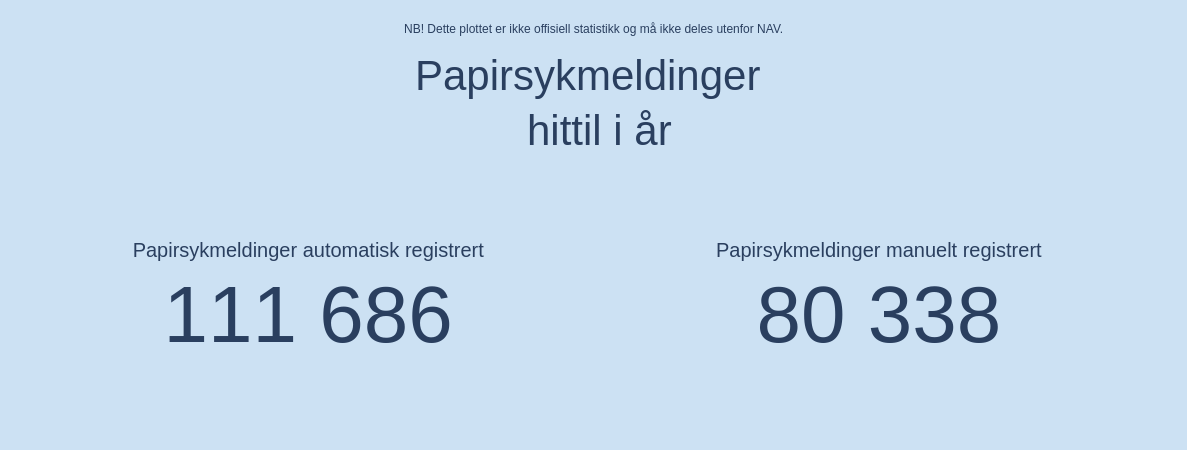

In [449]:
fig_nokkeltall_papir = go.Figure()

fig_nokkeltall_papir.add_trace(
    go.Indicator(
        mode = "number",
        value = num_papir_auto_nu,
        number = {"valueformat": ",d"},
        domain = {'column': 0, 
                  'row': 1},
        title = {'text': 'Papirsykmeldinger automatisk registrert'},
    )
)

fig_nokkeltall_papir.add_trace(
    go.Indicator(
        mode = "number",
        value = num_papir_manu_nu,
        number = {"valueformat": ",d"},
        domain = {'column': 1, 
                  'row':1},
        title = {'text': 'Papirsykmeldinger manuelt registrert'}
    )
)

fig_nokkeltall_papir.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.3,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)



fig_nokkeltall_papir.update_layout(
    autosize=True, 
    grid = {'rows': 2, 
            'columns': 2, 
            'pattern': "independent"}, 
    separators=', ', 
    paper_bgcolor= nokkeltall_farge ,                        
    title={'text': "Papirsykmeldinger <br> hittil i år", 
           'y':0.8,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    font={'size':30}, 
    height=450
)

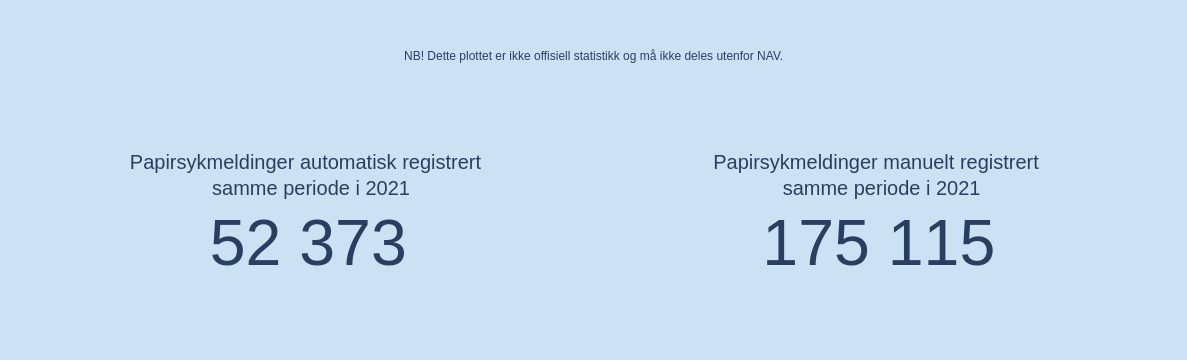

In [450]:
fig_nokkeltall_papir_forrige = go.Figure()

fig_nokkeltall_papir_forrige.add_trace(
    go.Indicator(
        mode = "number",
        value = num_papir_auto_forrige,
        number = {"valueformat": ",d"},
        domain = {'column': 0, 
                  'row': 1},
        title = {'text': f'Papirsykmeldinger automatisk registrert <br> samme periode i {papir_forrige_aar}'},
    )
)

fig_nokkeltall_papir_forrige.add_trace(
    go.Indicator(
        mode = "number",
        value = num_papir_manu_forrige,
        number = {"valueformat": ",d"},
        domain = {'column': 1, 
                  'row':1},
        title = {'text': f'Papirsykmeldinger manuelt registrert <br> samme periode i {papir_forrige_aar}'}
    )
)

fig_nokkeltall_papir_forrige.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.3,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)


fig_nokkeltall_papir_forrige.update_layout(
    autosize=True, 
    grid = {'rows': 2, 
            'columns': 2, 
            'pattern': "independent"},
    separators=', ', 
    paper_bgcolor=nokkeltall_farge , 
    height=300
)

In [451]:
###########################################
##### Visualisering Papirsykmeldinger #####
###########################################

df_papir_tot = df_papir.merge(df_registrering, how='left',on='dato')
df_papir_tot['Manuelt registrert'] = df_papir_tot['Manuelt registrert'].fillna(0)
df_papir_tot['Automatisk registrert'] = df_papir_tot['totalt'] - df_papir_tot['Manuelt registrert']

df_papir_tot = pd.melt(df_papir_tot, 
                       id_vars=['dato'], 
                       value_vars=['totalt', 'Manuelt registrert', 'Automatisk registrert'], 
                       var_name='reg', 
                       value_name='antall')

df_papir_tot = df_papir_tot[df_papir_tot['reg'] !='totalt']
df_papir_tot = df_papir_tot[df_papir_tot['dato'] != dt.datetime.now().date()]


# Grupperer på mnd #

df_papir_tot['mnd'] = df_papir_tot['dato'].astype('datetime64[ns]').dt.strftime('%Y/%m')
df_papir_tot = df_papir_tot[df_papir_tot['mnd'] != dt.datetime.now().date().strftime('%Y/%m')]
df_papir_tot_mnd = df_papir_tot.groupby(['mnd', 'reg']).sum().reset_index()

In [452]:
#############################################
### Finne andel papirsykmeldinger per mnd ###
#############################################

df_p_andel = df_papir.copy()
df_p_andel = df_p_andel.rename(columns={'totalt' : 'papirsykmeldinger'})
df_p_andel['dato'] = df_p_andel['dato'].astype('datetime64[ns]')

df_alle_andel = df.copy()
df_alle_andel = df_alle_andel.rename(columns={'antall' : 'totalt', 
                                              'mottatt_tidspunkt' : 'dato'})

df_andel_papir = df_alle_andel.merge(df_p_andel, on='dato')
df_andel_papir['mnd'] = df_andel_papir['dato'].dt.strftime('%Y/%m')
df_andel_papir_mnd = df_andel_papir.groupby(['mnd']).sum().reset_index()

df_andel_papir_mnd['andel'] = (df_andel_papir_mnd['papirsykmeldinger']/df_andel_papir_mnd['totalt']*100).round(1)
df_andel_papir_mnd = df_andel_papir_mnd[df_andel_papir_mnd['mnd'] != dt.datetime.now().date().strftime('%Y/%m')]
df_andel_papir_mnd = df_andel_papir_mnd[df_andel_papir_mnd['mnd'] >= '2021/01']

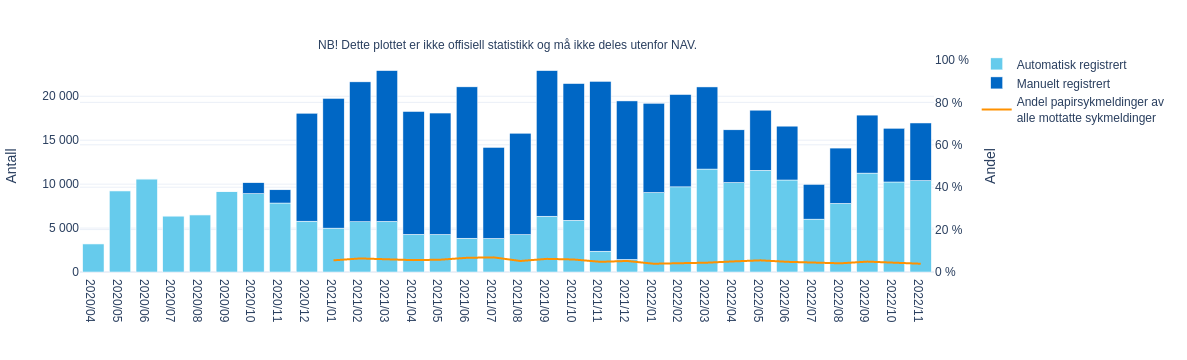

In [453]:
fig_papir_begge = px.bar(
    df_papir_tot_mnd, 
    x='mnd', 
    y='antall', 
    color='reg',
    labels={'antall': '', 
            'mnd' : '', 
            'reg' : ''},
    color_discrete_sequence = nav_kategorisk
)

                         


fig_papir_begge['data'][0]['hovertemplate'] = '<br />År/måned: %{x}<br />Antall: %{y}'
fig_papir_begge['data'][1]['hovertemplate'] = '<br />År/måned: %{x}<br />Antall: %{y}'

fig_papir_begge.update_xaxes(
    tickmode='array',  
    rangebreaks=[dict(bounds=['sat', 'mon']), 
                 dict(values=["2020-05-01", '2020-05-21', '2020-06-01'])]
)

fig_papir_begge.add_trace(
    go.Scatter(
        x=df_andel_papir_mnd['mnd'], 
        y=df_andel_papir_mnd['andel'], 
        yaxis="y2", 
        name='Andel papirsykmeldinger av <br>alle mottatte sykmeldinger', 
        marker_color='#FF9100'
    )
)

fig_papir_begge = fig_papir_begge.update_layout(
    yaxis2={
        'range': [0, 100],
        'side': 'right',
        'ticksuffix': ' %',
        'overlaying': 'y'
    },
    yaxis_title='Antall',
    yaxis2_title='Andel',
    legend={
        'x': 1.05,
        'y': 1.05
    },
    hovermode='x unified',
    hoverlabel={'namelength': -1},
    template="plotly_white",
    yaxis=dict(tickformat=',d'), 
    separators=', '
)

fig_papir_begge.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.12,
    font={'size':12},
    xref= 'paper',
    yref= 'paper',
)

In [454]:
################################################
#### Finner antall sykmeldte personer i dag ####
################################################
i_dag = dt.date.today().strftime('%Y-%m-%d')

query_job = client.query(f"""
select count( distinct so.pasient_fnr) antall
from `teamsykmelding-prod-2acd.syfosmregister.sykmeldingsdokument` sd, 
`teamsykmelding-prod-2acd.syfosmregister.sykmeldingsopplysninger` so, 
`teamsykmelding-prod-2acd.syfosmregister.sykmeldingstatus` ss
where so.id = sd.id
    and so.id = ss.sykmelding_id
    and CAST(JSON_EXTRACT_SCALAR(JSON_EXTRACT(sd.sykmelding, '$.perioder[0]'), "$.fom") AS DATE) <= CAST('{i_dag}' AS DATE)
    and CAST(JSON_EXTRACT_SCALAR(JSON_EXTRACT(sd.sykmelding, '$.perioder[0]'), "$.tom") AS DATE) >= CAST('{i_dag}' AS DATE) 
    and (ss.event = 'SENDT' or ss.event = 'BEKREFTET')
    
""")

df_personer = query_job.result().to_dataframe()

antall_sykmeldte_personer_idag = df_personer['antall'].sum()

In [455]:
#### Totalt sykmeldinger per år ####

df_ant = df_total.copy()
df_ant['År'] = df_ant['mottatt_tidspunkt'].dt.strftime('%Y')
df_ant['Uke+dag'] = df_ant['mottatt_tidspunkt'].dt.strftime('%V / %a')
df_ant['uke+dag_num'] = df_ant['mottatt_tidspunkt'].dt.strftime('%V / %u') 


### Setter en max uke/dag, slik at vi kun teller med samme periode for alle årene ### 
max_tid = dt.datetime.now().date().strftime('%V') + ' / ' + dt.datetime.now().strftime('%u') 

dagens_år = dt.date.today().strftime('%Y')
### Tar kun med de som er mindre enn maks uke/dag ###
df_ant = df_ant[(df_ant['uke+dag_num'] <= max_tid) | (df_ant['År'] == dagens_år)]

### Grupperer etter år ###
df_ant_aar = df_ant.copy()
df_ant_aar = df_ant_aar.groupby(['År']).sum().reset_index()

In [456]:
dagens_dato =  dt.date.today().strftime('%d/%m %Y')

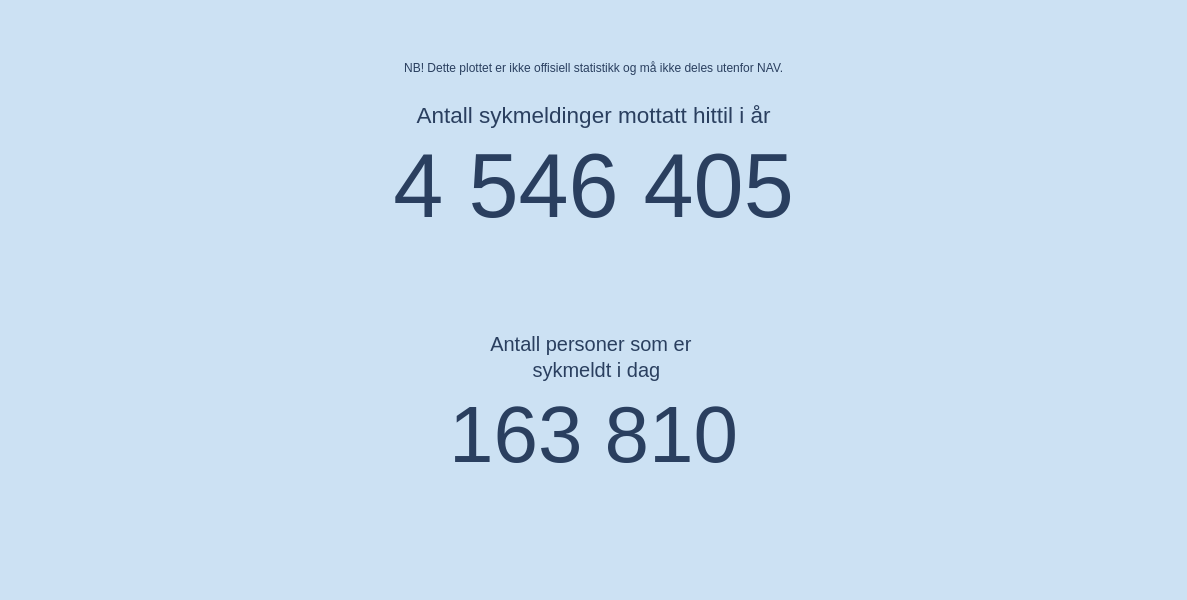

In [457]:
fig_nokkeltall = go.Figure()

num_iår = df_ant_aar[df_ant_aar['År'] == dagens_år]['antall'].sum()

fig_nokkeltall.add_trace(
    go.Indicator(
        mode = "number",
        value = num_iår,
        number = {"valueformat": ",d", 
                  'font':{'size':90}},
        domain = {'column': 0, 
                  'row': 0},
        title = {'text': 'Antall sykmeldinger mottatt hittil i år'}
    )
)


fig_nokkeltall.add_trace(
    go.Indicator(
        mode = "number",
        value = antall_sykmeldte_personer_idag,
        number = {"valueformat": ",g"},
        domain = {'column':0, 
                  'row':1},
        title = {'text': f'Antall personer som er <br> sykmeldt i dag'}
    )
)

fig_nokkeltall.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.1,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)




fig_nokkeltall.update_layout(
    autosize=True, 
    grid = {'rows': 2, 
            'columns': 1, 
            'pattern': "independent"}, 
    separators=', ', 
    paper_bgcolor=nokkeltall_farge, 
    height=600
)

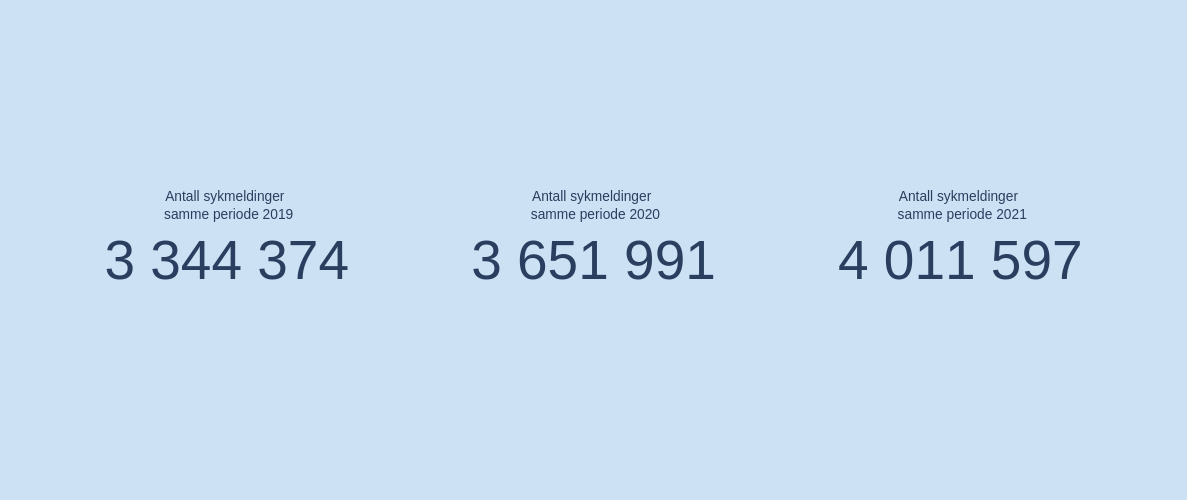

In [458]:
fig_nokkeltall_tid = go.Figure()
aar = df_ant_aar['År'].unique().tolist()
aar = aar[-4:-1]

for i in aar:
    
    number = df_ant_aar[df_ant_aar['År'] == i]['antall'].sum()
    
    fig_nokkeltall_tid.add_trace(
        go.Indicator(
            mode = "number",
            value = number,
            number = {"valueformat": ",d", 
                      'font':{'size':55}},
            domain = {'column': aar.index(i), 
                      'row': 1},
            title = {'text': f'Antall sykmeldinger <br> samme periode {i}'},
        )
    )
    
fig_nokkeltall_tid.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.4,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)


fig_nokkeltall_tid.update_layout(
    autosize=True, 
    grid = {'rows': 1, 
            'columns': 3, 
            'pattern': "independent"}, 
    separators=', ', 
    paper_bgcolor=nokkeltall_farge, 
    height=500
)

In [459]:
query_job = client.query("""
select count(so.id) antall, 
JSON_EXTRACT_SCALAR(JSON_EXTRACT(bh.behandlingsutfall, '$.status'), "$.") status,
CAST(so.mottatt_tidspunkt AS DATE) mottatt_tidspunkt
from `teamsykmelding-prod-2acd.syfosmregister.sykmeldingsopplysninger` so, 
`teamsykmelding-prod-2acd.syfosmregister.behandlingsutfall` bh                                                            
where so.id = bh.id                                                                                              
and so.mottatt_tidspunkt > DATETIME '2019-12-31'                                     
and JSON_EXTRACT(bh.behandlingsutfall, '$.status') IN ('"OK"', '"MANUAL_PROCESSING"', '"INVALID"')    
GROUP BY JSON_EXTRACT_SCALAR(JSON_EXTRACT(bh.behandlingsutfall, '$.status'), "$."), CAST(so.mottatt_tidspunkt AS DATE) 
""")


df_reg = query_job.result().to_dataframe()

In [460]:
query_job = client.query("""

select EXTRACT(DATE FROM DATETIME(JSON_EXTRACT_SCALAR(receivedsykmelding, "$.mottattDato"))) mottatt_tidspunkt,
     count(distinct id) antall
from `teamsykmelding-prod-2acd.syfosmmanuell_backend.manuelloppgave`
where ferdigstilt = True
and EXTRACT(DATE FROM DATETIME(JSON_EXTRACT_SCALAR(receivedsykmelding, "$.mottattDato"))) > CAST('2021-01-04' AS DATE)
group by EXTRACT(DATE FROM DATETIME(JSON_EXTRACT_SCALAR(receivedsykmelding, "$.mottattDato")))


""")


df_sysm_manuell = query_job.result().to_dataframe()

In [461]:
df_sysm_manuell['status'] = 'MANUAL_PROCESSING'

In [462]:
df_reg = pd.concat([df_reg, 
                    df_sysm_manuell], 
                   ignore_index=True)

In [463]:
df_eia = pd.read_csv('/home/jupyter/data-analyse-teamsykmelding/manuell_gammel_eia.csv')

In [464]:
df_eia_columns = ['antall', 'status', 'registrert']
df_eia.columns = df_eia_columns

In [465]:
df_reg['mottatt_tidspunkt']  = df_reg['mottatt_tidspunkt'].astype('datetime64[ns]')

df_eia['registrert'] = df_eia['registrert'].astype('datetime64[ns]')

In [466]:
# Lager uke og år
df_reg['uke'] = df_reg['mottatt_tidspunkt'].dt.strftime('%V')
df_reg['år'] = df_reg['mottatt_tidspunkt'].dt.year.astype(str)
df_reg = df_reg[df_reg['uke'] != dt.datetime.now().date().strftime('%V')]

df_eia['uke'] = df_eia['registrert'].dt.strftime('%V')
df_eia['år'] = df_eia['registrert'].dt.year.astype(str)

In [467]:
# Manuelle oppgaver
df_reg_manuell = df_reg[df_reg['status'] == 'MANUAL_PROCESSING'].copy()

df_reg_manuell['år'] = df_reg_manuell.apply(
    lambda x: ukenummer_fiks_aar(x['mottatt_tidspunkt'].strftime('%m'), x['uke'], x['år']), 
    axis=1
)
df_reg_manuell = df_reg_manuell.groupby(['uke', 'år']).sum().reset_index()

df_eia_manuell = df_eia[df_eia['status'] == 'MANUELL BEHANDLING']
df_eia_manuell = df_eia_manuell.groupby(['uke', 'år']).sum().reset_index()

df_manuell = pd.concat([df_eia_manuell, 
                        df_reg_manuell], 
                       ignore_index=True).groupby(['uke', 'år']).sum().reset_index()

In [468]:
fig_manuell = px.area(
    df_manuell, 
    x='uke', 
    y='antall', 
    facet_col='år', 
    color='år', 
    hover_name='år',
    labels={'år': 'År', 
            'uke': 'Ukenummer', 
            'antall': ''}, 
    color_discrete_sequence = nav_kategorisk
)


fig_manuell.update_layout(
    yaxis=dict(tickformat=',d'), 
    separators=', ', 
    hovermode='x unified', 
    template="plotly_white"
)


fig_manuell.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.13,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)



fig_manuell.for_each_trace(
    lambda trace: trace.update(name=trace.name.replace("=", ": " )),
)

fig_manuell.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

for i in range(-1,3):
    fig_manuell['data'][i]['hovertemplate'] = '<b>%{hovertext}</b> <br />Ukenummer: %{x}<br />Antall: %{y:, f}<extra></extra>'

In [469]:
df_reg_pivot = pd.pivot_table(
    df_reg, 
    values='antall', 
    index=['mottatt_tidspunkt', 
           'uke', 
           'år'], 
    columns='status',
    fill_value=0
).reset_index()

df_reg_pivot['total'] = df_reg_pivot.sum(axis=1, numeric_only=True)

df_reg_pivot['år'] = df_reg_pivot.apply(
    lambda x: ukenummer_fiks_aar(x['mottatt_tidspunkt'].strftime('%m'), x['uke'], x['år']), 
    axis=1
)


df_reg_pivot_g = df_reg_pivot.groupby(['uke', 'år']).sum().reset_index()
df_reg_pivot_g['andel_manuell'] = (df_reg_pivot_g['MANUAL_PROCESSING']/df_reg_pivot_g['total']*100).round()

In [470]:
df_eia_pivot = pd.pivot_table(
    df_eia, 
    values='antall', 
    index=['registrert', 'uke', 'år'], 
    columns='status',
    fill_value=0
).reset_index()

df_eia_pivot['total'] = df_eia_pivot.sum(axis=1, numeric_only=True)


df_eia_pivot_g = df_eia_pivot.groupby(['uke', 'år']).sum().reset_index()

df_eia_pivot_g['andel_manuell'] = (df_eia_pivot_g['MANUELL BEHANDLING']/df_eia_pivot_g['total']*100).round()

In [471]:
df_pivot_g = pd.concat([df_reg_pivot_g[['uke', 'år', 'andel_manuell']],
                       df_eia_pivot_g[['uke', 'år', 'andel_manuell']]], 
                       ignore_index=True
                      ).groupby(['uke', 'år']).sum().reset_index()

In [472]:
fig_andel_m = px.line(
    df_pivot_g, 
    x='uke', 
    y='andel_manuell', 
    facet_col='år',
    color='år', 
    hover_name='år',
    labels={'år': 'År', 
            'uke': 'Ukenummer', 
            'antall': '', 
            'andel_manuell' : 'Prosentandel'}, 
    color_discrete_sequence = nav_kategorisk
)


fig_andel_m.update_layout(
    yaxis=dict(tickformat=',d'), 
    separators=', ', 
    hovermode='x unified', 
    template="plotly_white"
)


fig_andel_m.for_each_trace(
    lambda trace: trace.update(name=trace.name.replace("=", ": " )),
)

fig_andel_m.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig_andel_m.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.13,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)


for i in range(-1,3):
    fig_andel_m['data'][i]['hovertemplate'] = '<b>%{hovertext}</b> <br />Ukenummer: %{x}<br />Prosentandel: %{y:, f}%<extra></extra>'

In [473]:
# Avviste sykmeldinger
df_reg_avvist = df_reg[df_reg['status'] == 'INVALID'].copy()

df_reg_avvist['år'] = df_reg_avvist.apply(
    lambda x: ukenummer_fiks_aar(x['mottatt_tidspunkt'].strftime('%m'), x['uke'], x['år']),
    axis=1
)
df_reg_avvist = df_reg_avvist.groupby(['uke', 'år']).sum().reset_index()

df_eia_avvist = df_eia[df_eia['status'] == 'AVVIST']
df_eia_avvist = df_eia_avvist.groupby(['uke', 'år']).sum().reset_index()

df_avvist = pd.concat([df_eia_avvist, 
                       df_reg_avvist], 
                      ignore_index=True).groupby(['uke', 'år']).sum().reset_index()

In [474]:
fig_avvist = px.area(
    df_avvist, 
    x='uke', 
    y='antall', 
    facet_col='år', 
    color='år', 
    hover_name='år',
    labels={'år': 'År', 
            'uke': 'Ukenummer', 
            'antall': ''}, 
    color_discrete_sequence = nav_kategorisk
)


fig_avvist.update_layout(
    yaxis=dict(tickformat=',d'), 
    separators=', ', 
    hovermode='x unified', 
    template="plotly_white"
)

fig_avvist.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.13,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)


fig_avvist.for_each_trace(
    lambda trace: trace.update(name=trace.name.replace("=", ": " )),
)

fig_avvist.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

for i in range(-1,3):
    fig_avvist['data'][i]['hovertemplate'] = '<b>%{hovertext}</b> <br />Ukenummer: %{x}<br />Antall: %{y:, f}<extra></extra>'

In [475]:
df_eia_pivot_ag = df_eia_pivot.groupby(['uke', 'år']).sum().reset_index()

df_eia_pivot_ag['andel_avvist'] = (df_eia_pivot_ag['AVVIST']/df_eia_pivot_ag['total']*100).round()

In [476]:
df_reg_pivot_ag = df_reg_pivot.groupby(['uke', 'år']).sum().reset_index()
df_reg_pivot_ag['andel_avvist'] = (df_reg_pivot_ag['INVALID']/df_reg_pivot_ag['total']*100).round()

In [477]:
df_pivot_ag = pd.concat([df_reg_pivot_ag[['uke', 'år', 'andel_avvist']],
                         df_eia_pivot_ag[['uke', 'år', 'andel_avvist']]], 
                        ignore_index=True).groupby(['uke', 'år']).sum().reset_index()

In [478]:
fig_andel_a = px.line(
    df_pivot_ag, 
    x='uke', 
    y='andel_avvist', 
    facet_col='år',
    color='år', 
    hover_name='år',
    labels={'år': 'År', 
            'uke': 'Ukenummer', 
            'antall': '', 
            'andel_avvist' : 'Prosentandel'}, 
    color_discrete_sequence = nav_kategorisk
)


fig_andel_a.update_layout(
    yaxis=dict(tickformat=',d'), 
    separators=', ', 
    hovermode='x unified', 
    template="plotly_white"
)


fig_andel_a.for_each_trace(
    lambda trace: trace.update(name=trace.name.replace("=", ": " )),
)

fig_andel_a.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig_andel_a.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.13,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)

for i in range(-1,3):
    fig_andel_a['data'][i]['hovertemplate'] = '<b>%{hovertext}</b> <br />Ukenummer: %{x}<br />Prosentandel: %{y:, f}%<extra></extra>'

In [479]:
query_job = client.query("""
select 
    count(so.id) antall, 
    JSON_EXTRACT_SCALAR(JSON_EXTRACT(bh.behandlingsutfall, '$.status'), "$.") status, 
    CAST(so.mottatt_tidspunkt AS DATE) mottatt_tidspunkt,
    case when JSON_EXTRACT_SCALAR(JSON_EXTRACT(bh.behandlingsutfall, '$.status[0]'), "$.ruleName") is not null 
        then JSON_EXTRACT_SCALAR(JSON_EXTRACT(bh.behandlingsutfall, '$.status[0]'), "$.ruleName") 
    else 'OK' end regeltreff
from `teamsykmelding-prod-2acd.syfosmregister.sykmeldingsopplysninger` so, `teamsykmelding-prod-2acd.syfosmregister.behandlingsutfall` bh                                                             
where so.id = bh.id                                                                                              
    and so.mottatt_tidspunkt > DATETIME '2019-01-01'                                              
GROUP BY JSON_EXTRACT_SCALAR(JSON_EXTRACT(bh.behandlingsutfall, '$.status'), "$."), CAST(so.mottatt_tidspunkt AS DATE), 
    case when JSON_EXTRACT_SCALAR(JSON_EXTRACT(bh.behandlingsutfall, '$.status[0]'), "$.ruleName") is not null 
        then JSON_EXTRACT_SCALAR(JSON_EXTRACT(bh.behandlingsutfall, '$.status[0]'), "$.ruleName")  
    else 'OK' end
""")    
    
df_regeltreff = query_job.result().to_dataframe()

In [480]:
df_regeltreff_manuell = df_regeltreff[df_regeltreff['status'] == 'MANUAL_PROCESSING'].copy()

In [481]:
##########################################################################################
### Ny kolonne med klassifikasjon, husk å velge om det er med eller uten gammle regler ###
##########################################################################################

df_regeltreff_manuell['source'] = df_regeltreff_manuell['regeltreff'].map(map_regel_manu)

##########################################
### Legger til data fra syfosmmanuell  ###     
##########################################
df_sysm_manuell['source'] = 'Manuell'


df_regeltreff_manuell = pd.concat([df_regeltreff_manuell, 
                                   df_sysm_manuell[['mottatt_tidspunkt', 'antall', 'source']]]
                                 )



In [482]:
########## Passer på at tidspunkt er datetime-format ##################

df_regeltreff_manuell['mottatt_tidspunkt'] = df_regeltreff_manuell['mottatt_tidspunkt'].astype('datetime64[ns]')

####### Lager ny kolonne med år/uke ###########
df_regeltreff_manuell['aar_uke'] = df_regeltreff_manuell['mottatt_tidspunkt'].dt.strftime('%Y / %V') 

In [483]:
#### Fikser krøll med år/uke i årss
df_regeltreff_manuell_grouped = df_regeltreff_manuell.copy()
df_regeltreff_manuell_grouped = df_regeltreff_manuell_grouped[
    ((df_regeltreff_manuell_grouped['mottatt_tidspunkt'].dt.strftime('%V') >= dt.datetime.now().strftime('%V'))
    & (df_regeltreff_manuell_grouped['mottatt_tidspunkt'].dt.strftime('%Y').astype('int') == int(dt.datetime.now().strftime('%Y')) - 1))
    |
    ((df_regeltreff_manuell_grouped['mottatt_tidspunkt'].dt.strftime('%V') < dt.datetime.now().strftime('%V'))
    & (df_regeltreff_manuell_grouped['mottatt_tidspunkt'].dt.strftime('%Y').astype('int') == int(dt.datetime.now().strftime('%Y'))))
].groupby(['aar_uke','source']).sum().reset_index()


In [484]:
df_regeltreff_manuell_grouped = df_regeltreff_manuell_grouped[df_regeltreff_manuell_grouped['source'] != 'Avvist']

In [485]:
df_regeltreff_avvist = df_regeltreff[df_regeltreff['status'] == 'INVALID'].copy()

In [486]:
df_regeltreff_avvist['mottatt_tidspunkt'] = df_regeltreff_avvist['mottatt_tidspunkt'].astype('datetime64[ns]')

In [487]:
df_regeltreff_avvist = df_regeltreff_avvist.copy()
df_regeltreff_avvist['source'] = 'Avvist'

In [488]:
df_regeltreff_avvist['aar_uke'] = df_regeltreff_avvist['mottatt_tidspunkt'].dt.strftime('%Y / %V')

In [489]:
df_regeltreff_avvist_grouped = df_regeltreff_avvist.copy()
df_regeltreff_avvist_grouped = df_regeltreff_avvist_grouped[
    ((df_regeltreff_avvist_grouped['mottatt_tidspunkt'].dt.strftime('%V') >= dt.datetime.now().strftime('%V'))
    & (df_regeltreff_avvist_grouped['mottatt_tidspunkt'].dt.strftime('%Y').astype('int') == int(dt.datetime.now().strftime('%Y')) - 1))
    |
    ((df_regeltreff_avvist_grouped['mottatt_tidspunkt'].dt.strftime('%V') < dt.datetime.now().strftime('%V'))
    & (df_regeltreff_avvist_grouped['mottatt_tidspunkt'].dt.strftime('%Y').astype('int') == int(dt.datetime.now().strftime('%Y'))))
].groupby(['aar_uke','source']).sum().reset_index()

In [490]:
df_regeltreff_ok = df_regeltreff[df_regeltreff['status'] == 'OK'].copy()
df_regeltreff_ok['mottatt_tidspunkt'] = df_regeltreff_ok['mottatt_tidspunkt'].astype('datetime64[ns]')
df_regeltreff_ok['source'] = 'OK'
df_regeltreff_ok['aar_uke'] = df_regeltreff_ok['mottatt_tidspunkt'].dt.strftime('%Y / %V') 

In [491]:
df_regeltreff_ok_grouped = df_regeltreff_ok.copy()
df_regeltreff_ok_grouped = df_regeltreff_ok_grouped[
    ((df_regeltreff_ok_grouped['mottatt_tidspunkt'].dt.strftime('%V') >= dt.datetime.now().strftime('%V'))
    & (df_regeltreff_ok_grouped['mottatt_tidspunkt'].dt.strftime('%Y').astype('int') == int(dt.datetime.now().strftime('%Y')) - 1))
    |
    ((df_regeltreff_ok_grouped['mottatt_tidspunkt'].dt.strftime('%V') < dt.datetime.now().strftime('%V'))
    & (df_regeltreff_ok_grouped['mottatt_tidspunkt'].dt.strftime('%Y').astype('int') == int(dt.datetime.now().strftime('%Y'))))
].groupby(['aar_uke','source']).sum().reset_index()

In [492]:
df_alle_behandlingsutfall = pd.concat([df_regeltreff_ok_grouped, 
                                       df_regeltreff_manuell_grouped, 
                                       df_regeltreff_avvist_grouped])

In [493]:
df_alle_behandlingsutfall_grouped = df_alle_behandlingsutfall.copy()
df_alle_behandlingsutfall_grouped = df_alle_behandlingsutfall_grouped.groupby(['aar_uke', 'source']).sum().reset_index()

In [494]:
df_alle_behandlingsutfall_grouped = df_alle_behandlingsutfall_grouped[(df_alle_behandlingsutfall_grouped['aar_uke'] > '2019 / 39') 
                                                                      & (df_alle_behandlingsutfall_grouped['source'] != 'Ukjent')]

In [495]:
input_dropdown = alt.binding_select(
    options=df_alle_behandlingsutfall_grouped['source'].unique().tolist(), 
    name='Behandlingsutfall '
)

selection = alt.selection_single(
    fields=['source'], 
    bind=input_dropdown, 
    name='Behandlingsutfall',  
    clear='dblclick'
)

color = alt.condition(
    selection,
    alt.Color(
        'source:N', 
        title='', 
        scale= alt.Scale(range=nav_kat_for)), 
    alt.value('lightgray')
)

fig_ford = alt.Chart(df_alle_behandlingsutfall_grouped).mark_area(opacity=0.7).encode(
    x=alt.X('aar_uke', title = '', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('antall', title=''),
    color=color,
    tooltip=[alt.Tooltip('antall:Q', title='Antall sykmeldinger'), 
               alt.Tooltip('aar_uke:N', title='År og ukenummer'), 
               alt.Tooltip('source:N', title='Behandlingsutfall')]
).properties(
    height = 450
).add_selection(
    selection
)

In [496]:
query_job = client.query("""
select
     EXTRACT(DATE FROM DATETIME(JSON_EXTRACT_SCALAR(receivedsykmelding, "$.mottattDato"))) mottattdato,
     count(distinct id) antall,
     JSON_EXTRACT_SCALAR(JSON_EXTRACT(receivedsykmelding, '$.merknader[0]'), "$.type") merknad_type,
     JSON_EXTRACT_SCALAR(JSON_EXTRACT(validationresult, '$.status'), "$.") behandlingsutfall,
from `teamsykmelding-prod-2acd.syfosmmanuell_backend.manuelloppgave`
where ferdigstilt = True
     group by EXTRACT(DATE FROM DATETIME(JSON_EXTRACT_SCALAR(receivedsykmelding, "$.mottattDato"))),  JSON_EXTRACT_SCALAR(JSON_EXTRACT(receivedsykmelding, '$.merknader[0]'), "$.type"), 
    JSON_EXTRACT_SCALAR(JSON_EXTRACT(validationresult, '$.status'), "$.")

""")


df_resultat = query_job.result().to_dataframe()

In [497]:
df_resultat['status'] = df_resultat.apply(
    lambda x: make_status(x['merknad_type'], x['behandlingsutfall']), 
    axis=1
)

In [498]:
df_resultat_status = df_resultat.groupby(['mottattdato', 'status']).sum().reset_index()

In [499]:
df_resultat_grouped = df_resultat.groupby('mottattdato').sum().reset_index()
df_resultat_grouped['status'] = 'Antall'

In [500]:
df_resultat_pivot = pd.pivot_table(
    df_resultat_status, 
    index=['mottattdato'], 
    columns='status', 
    values='antall', 
    fill_value=0
).reset_index()

df_resultat_pivot = df_resultat_pivot[['mottattdato', 'INVALID', 'OK']]
df_resultat_pivot['total'] = df_resultat_pivot.sum(axis=1, numeric_only=True)
df_resultat_pivot['andel_ok'] = (df_resultat_pivot['OK']/df_resultat_pivot['total']*100).round(1)

In [501]:
fig_resultat = px.bar(
    df_resultat_grouped, 
    x='mottattdato', 
    y='antall', 
    color='status',
    labels={'status':'', 'mottattdato' : 'Mottatt dato'},  
    color_discrete_sequence = nav_kategorisk
)


fig_resultat.add_trace(
    go.Scatter(
        x=df_resultat_pivot['mottattdato'], 
        y=df_resultat_pivot['andel_ok'], 
        yaxis="y2", name='Andel OK', 
        marker_color='#0067C5'
    )
)

fig_resultat = fig_resultat.update_layout(
    yaxis2={'range': [0, 100],
            'side': 'right',
            'ticksuffix': ' %',
            'overlaying': 'y'},
    yaxis_title='Antall',
    yaxis2_title='Andel',
    legend={'x': 1.05,
            'y': 1.05},
    hovermode='x unified',
    hoverlabel={'namelength': -1},
)

fig_resultat.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.13,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)


fig_resultat.update_layout(
    yaxis=dict(tickformat=',d'), 
    separators=', ', 
    hovermode='x unified', 
    template="plotly_white"
)

fig_resultat['data'][0]['hovertemplate'] = 'Antall ferdigstilt: %{y:, f}<extra></extra>'

In [502]:
query_job = client.query("""

select count(id) antall,
     DATETIME(JSON_EXTRACT_SCALAR(receivedsykmelding, "$.mottattDato")) mottattdato,
       case 
           when JSON_EXTRACT_SCALAR(JSON_EXTRACT(receivedsykmelding, '$.merknader[0]'), "$.type") = 'UGYLDIG_TILBAKEDATERING' then 'Avslått'
           when JSON_EXTRACT_SCALAR(JSON_EXTRACT(receivedsykmelding, '$.merknader[0]'), "$.type") = 'TILBAKEDATERING_KREVER_FLERE_OPPLYSNINGER' then 'Trenger mer informasjon' 
           else JSON_EXTRACT_SCALAR(JSON_EXTRACT(validationresult, '$.status'), "$.")
        end status
from `teamsykmelding-prod-2acd.syfosmmanuell_backend.manuelloppgave`
where ferdigstilt is True
group by DATETIME(JSON_EXTRACT_SCALAR(receivedsykmelding, "$.mottattDato")), status


""")


df_merknad = query_job.result().to_dataframe()


In [503]:
df_merknad = df_merknad[df_merknad['status'] != 'MANUAL_PROCESSING']
df_merknad = df_merknad.replace({'OK' : 'Ok', 
                                 'INVALID' : 'Avvist'})
df_merknad['Uke'] = df_merknad['mottattdato'].astype('datetime64[ns]').dt.strftime('%Y/%V')

In [504]:


df_merknad['Uke'] = df_merknad.apply(
    lambda x: ukenummer_fiks_uke(x['Uke'], x['mottattdato']), 
    axis=1
)

df_merknad_grouped = df_merknad.groupby(['Uke', 'status']).sum().reset_index()

df_merknad_grouped = df_merknad_grouped[(df_merknad_grouped['Uke'] > '2020/53') & 
                                        (df_merknad_grouped['Uke']  != dt.datetime.now().date().strftime('%Y/%V'))]



In [505]:


df_merknad_pivot = pd.pivot_table(
    df_merknad_grouped, 
    values='antall', 
    index='Uke', 
    columns='status', 
    fill_value=0
).reset_index()

df_merknad_pivot['totalt'] = df_merknad_pivot.sum(axis=1, numeric_only=True)
df_merknad_pivot['andel_avslått'] = (df_merknad_pivot['Avslått']/df_merknad_pivot['totalt']*100).round(1)
df_merknad_pivot['andel_avvist'] = (df_merknad_pivot['Avvist']/df_merknad_pivot['totalt']*100).round(1)
df_merknad_pivot['andel_ok'] = (df_merknad_pivot['Ok']/df_merknad_pivot['totalt']*100).round(1)
df_merknad_pivot['andel_mer_info'] = (df_merknad_pivot['Trenger mer informasjon']/df_merknad_pivot['totalt']*100).round(1)



In [506]:


fig_merknad = px.bar(
    df_merknad_grouped, 
    x='Uke', 
    y='antall', 
    color='status', 
    barmode='group', 
    hover_name='status', 
    labels={'status' : 'Status', 
            'antall':''}, 
    category_orders = {
        'status':['Ok', 'Avvist', 'Trenger mer informasjon', 'Avslått']
    }, 
    color_discrete_sequence = nav_kategorisk
)

fig_merknad.update_layout(
    yaxis=dict(tickformat=',g'), 
    separators=', ', 
    hovermode='x unified', 
    template="plotly_white"
                         )

fig_merknad.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.13,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)

for i in range(-1,3):
    fig_merknad['data'][i]['hovertemplate'] = '<b>%{hovertext}</b> <br />År og ukenummer: %{x}<br />Antall: %{y:, f}<extra></extra>'



In [507]:
query_job = client.query("""
with ranked as (
  select sykmelding_id, event, CAST(timestamp as DATE) timestamp, dense_rank() over (partition by sykmelding_id order by timestamp desc) rank from `teamsykmelding-prod-2acd.syfosmregister.sykmeldingstatus` 
where CAST(timestamp as DATE) >= DATE('2020-01-01'))
select count(sykmelding_id) antall, event, timestamp from ranked where rank =1
group by event, timestamp

""")

df_status = query_job.result().to_dataframe()

In [508]:


df_status['timestamp'] = pd.to_datetime(df_status['timestamp'])
df_status['timestamp'] = df_status['timestamp'].dt.date
df_status['dager_siden'] = df_status['timestamp'].apply(lambda x: dt.date.today() - x)
df_status['dager_siden'] = df_status['dager_siden'].dt.days

df_status['status'] = df_status.apply(
    lambda x: er_ubrukt(x['event'], x['dager_siden']),
    axis=1
)

df_status['timestamp'] = df_status['timestamp'].apply(
    lambda x: round(dt.datetime(day=x.day, month=x.month, year=x.year).timestamp())
)



In [509]:
df_status_pivot = pd.pivot_table(
    df_status, 
    values = ['antall'],
    index=['timestamp'], 
    columns=['status'], 
    fill_value= np.nan
).reset_index()

df_status_pivot.columns = df_status_pivot.columns.droplevel()

df_status_pivot[''] = df_status_pivot[''].apply(
    lambda x: x if np.isnan(x) else dt.date.fromtimestamp(x)
)
df_status_pivot = df_status_pivot.fillna(0)
df_status_pivot['Totalt'] = df_status_pivot.sum(axis=1, numeric_only=True)
df_status_pivot = df_status_pivot.rename(columns={'' : 'Dato'})

df_status_pivot['Måned'] = df_status_pivot['Dato'].astype('datetime64[ns]').dt.strftime('%m')
df_status_pivot['År'] = df_status_pivot['Dato'].astype('datetime64[ns]').dt.strftime('%Y')

df_status_mnd = df_status_pivot.groupby(['År', 'Måned']).sum().reset_index()


df_status_mnd_melt = pd.melt(
    df_status_mnd, 
    id_vars=['År', 'Måned', 'Totalt'], 
    value_vars=['APEN', 'AVBRUTT', 'BEKREFTET', 'SENDT', 'Ubrukt'], 
    var_name='status', 
    value_name='antall'
)
df_status_mnd_melt = df_status_mnd_melt.replace({'SENDT' : 'Sendt til arbeidsgiver', 
                                                 'Ubrukt': 'Ikke tatt i bruk', 
                                                 'BEKREFTET' : 'Bekreftet', 
                                                 'AVBRUTT' : 'Avbrutt', 
                                                 'APEN' : 'Åpen'})

In [510]:
fig_status_sykmelding = px.area(
    df_status_mnd_melt, 
    x='Måned', 
    y='antall', 
    facet_col='År', 
    color='status', 
    hover_name='År',
    labels={'mnd': 'Måned', 
            'antall': '', 
            'status' : 'Status'}, 
    color_discrete_sequence = nav_kategorisk,
    category_orders={"Måned": ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']}
)


fig_status_sykmelding.update_layout(
    yaxis=dict(tickformat=',d'), 
    separators=', ', 
    hovermode='x unified', 
    template="plotly_white"
)

fig_status_sykmelding.add_annotation(
    text = annotation_text,
    showarrow= False, 
    align= 'center',
    x= 0.5,
    y= 1.13,
    font={'size':12},
    xref= 'paper',
    yref= 'paper'
)



fig_status_sykmelding.for_each_trace(
    lambda trace: trace.update(name=trace.name.replace("=", ": " )),
)

fig_status_sykmelding.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

for i in range(-1,14):
    fig_status_sykmelding['data'][i]['hovertemplate'] = '<b>%{hovertext}</b> <br />Måned: %{x}<br />Antall: %{y:, f}<extra></extra>'

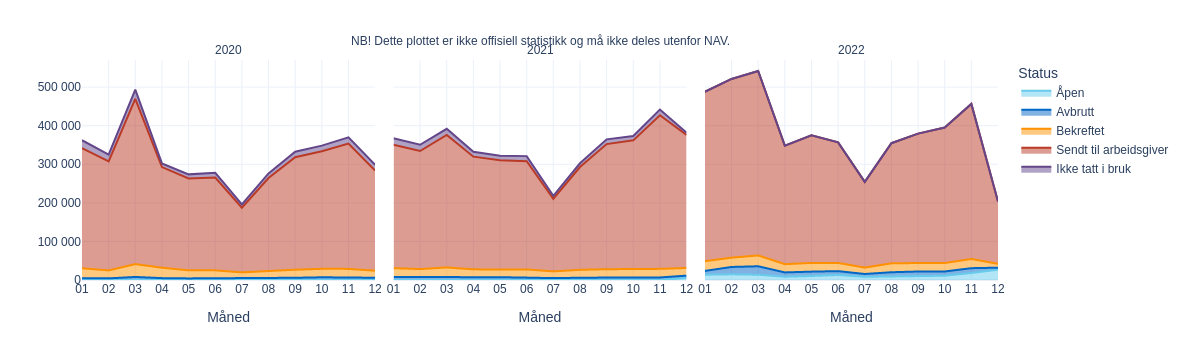

In [511]:
fig_status_sykmelding

In [512]:
os.environ["no_proxy"] = "localhost,127.0.0.1,10.254.0.1,.local,.adeo.no,.aetat.no,.devillo.no,.oera.no,.nais.io,.aivencloud.com"

In [513]:
from google.cloud import secretmanager
secrets = secretmanager.SecretManagerServiceClient()

resource_name = f"projects/71011284562/secrets/teamsykmelding_datastory_token_prod/versions/latest"
secret = secrets.access_secret_version(name=resource_name)
dstoken = secret.payload.data.decode('UTF-8')

In [514]:
ds = DataStory("Team sykmelding - tall og statistikk")

ds.header('')
ds.markdown("Team sykmelding bruker data som et verktøy til å følge med på sykmeldingene og hvor mange sykmeldinger vi mottar per dag. På denne måten avdekker vi raskt endringer. ")

ds.header("Nøkkeltall", level=2)
ds.plotly(plio.to_json(fig_nokkeltall))
ds.plotly(plio.to_json(fig_nokkeltall_tid))

ds.header("Antall sykmeldinger", level=2)
ds.plotly(plio.to_json(fig_sykmeldinger))
ds.markdown('''Team sykmelding bruker grafen som et verktøy til å følge med på hvor mange sykmeldinger vi mottar per dag. 
Vi sammenlikner dette med tallene fra foregående år. På denne måten avdekker vi raskt endringer. 
Dette inkluderer ikke sykmeldinger som er automatisk avvist''')

ds.header("Nøkkeltall papirsykmeldinger", level=2)
ds.plotly(plio.to_json(fig_nokkeltall_papir))
ds.plotly(plio.to_json(fig_nokkeltall_papir_forrige))

ds.header("Antall papirsykmeldinger per måned", level=2)
ds.plotly(plio.to_json(fig_papir_begge))
ds.markdown('''Grafen viser forholdet mellom papirsykmeldinger som har blitt automatisk tolket og 
de som har blitt manuelt registert. 
Samt andel papirsykmeldinger av totalt antall mottatte sykmeldinger per måned.''')

ds.header("Antall manuelle oppgaver per uke", level=2)
ds.plotly(plio.to_json(fig_manuell))

ds.header("Prosentandel manuelle oppgaver per uke", level=2)
ds.plotly(plio.to_json(fig_andel_m))

ds.header("Antall avviste sykmeldinger per uke", level=2)
ds.plotly(plio.to_json(fig_avvist))
ds.markdown('')

ds.header("Prosentandel avviste sykmeldinger per uke", level=2)
ds.plotly(plio.to_json(fig_andel_a))

ds.header("Behandlingsutfall", level=2)
ds.vega(fig_ford.to_json())
ds.markdown('Grafen viser andelen sykmeldinger som avvises, går til manuell behandling eller er ok. Bruk dropdown for å se behandlingsutfallene hver for seg. Dobbeltklikk på grafen for å se alle behandlingsutfall. NB! Dette plottet er ikke offisiell statistikk og må ikke deles utenfor NAV.')

ds.header("Tilbakedaterte sykmeldinger som er sendt til manuell behandling", level=2)
ds.plotly(plio.to_json(fig_resultat))
ds.markdown('Antall tilbakedaterte sykmeldinger som går til manuell behandling og andel av disse som godkjennes. For de som ikke godkjennes er det to kategorier: ugyldig tilbakedatering og trenger mer informasjon. Hva som skjer med de som ikke er godkjent etter dette punktet er utenfor våre systemer.')

ds.plotly(plio.to_json(fig_merknad))
ds.markdown('Status for tilbakedaterte sykmeldinger etter at manuell behandling er ferdigstilt per uke')

#ds.plotly(plio.to_json(fig_status_sykmelding))
#ds.markdown('Sykmeldinger som har blitt tatt i bruk eller ikke. Sykmeldinger regnes her som ikke tatt i bruk dersom de har status åpen og er eldre enn 1 år.')

ds.update(token=dstoken, url="https://nada.intern.nav.no/api")

'https://data.intern.nav.no/story/fc5c7a57-18e5-493f-8819-9200945c31ce'